# I 320D: Open Source Software Development - Final Project Notebook

### Professor: James Howison

### University of Texas at Austin School of Information

### Notebook Written by Alec McGhie

[![GitHub](https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/AlecMcGhie)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/alec-mcghie/)
[![Email](https://img.shields.io/badge/Email-D14836?style=for-the-badge&logo=gmail&logoColor=white)](mailto:mcghie.alec@gmail.com)

---

# Notebook overview

Through this project we will seek to find correlation between GitHub repository commits and how they relate to the release of new updates. This project aims to create prediction models to test and see what the expected amount of commits will be in the next cycle so that maintainers can prepare for the amount of work that they will have by seeing the projected amount of commits before the next update.  

---

# **Data overview**

## [PyDriller](https://github.com/ishepard/pydriller)

PyDriller is a Python library used for collecting data surrounding open source projects on GitHub. I chose to use this framework to avoid reaching the maximum limit that GitHub has for its built in Python API. Through its many different use cases PyDriller is able to take in reletivly simple commands and output a dataframe with much more in-depth features than the dataset provided in our I320D: Open Source Software Development course.


### Commit Data

Using PyDriller's `traverse_commits()` function, we can extract detailed commit information. The format for `commit_df`:

| hash | author_date | message | merge | in_main_branch | num_insertions | num_deletions | net_lines | num_files |
|------|-------------|---------|-------|----------------|----------------|---------------|-----------|-----------|
| 634b23a | 2020-03-08 18:46:33-05:00 | Initial commit | False | True | 130 | 0 | 130 | 2 |
| 188add0 | 2020-03-08 21:17:59-05:00 | Working pytorch implementation of the Temporal... | False | True | 2888 | 0 | 2888 | 8 |
| f1727d3 | 2020-03-08 21:50:11-05:00 | reorginizing folders | False | True | 10 | 10 | 0 | 12 |
| e4dcb41 | 2020-03-08 21:56:43-05:00 | updating training notebook | False | True | 160 | 158 | 2 | 1 |
| c1fde43 | 2020-03-08 22:21:54-05:00 | updating readme file | False | True | 14 | 1 | 13 | 1 |

### Release Data

PyDriller can also be used to extract release information by analyzing tags in the repository. We can identify releases by examining tag messages and dates, creating a structured dataset of release information. The format for `release_df`:

| tag_name | tag_message | tag_date |
|----------|-------------|----------|
| 0.2.2 |  | 2020-08-23 18:06:30+01:00 |
| v0.10.0 |  | 2022-03-23 12:50:58+00:00 |
| v0.10.1 |  | 2022-03-24 21:25:58+00:00 |
| v0.10.2 |  | 2022-05-23 12:47:11+01:00 |

---
To update the notebook structure and reflect the actual project and its code, we can break down the sections according to your specific project and the relevant steps involved. Here's a modified structure based on the given content that organizes the notebook content more clearly while making sure that the code flows logically through the steps:

---

# **Analysis Overview**

[![PyTorch Forecasting Logo](https://raw.githubusercontent.com/sktime/pytorch-forecasting/main/docs/source/_static/logo.svg)](https://github.com/sktime/pytorch-forecasting)

In this notebook, we analyze commit patterns and software releases in the PyTorch Forecasting repository. The analysis uses `PyDriller` to extract commit history and release data from the repository. The project employs a linear regression model to predict commit volume based on various features, evaluate model performance, and visualize future commit behavior for the next 30 days.

---

# **Project Structure**

This notebook is organized as follows to analyze the relationship between commit patterns and software releases in the PyTorch Forecasting repository:

- **0. Environment Setup and Dependencies**  
  - Install required Python packages (`PyDriller`, `pandas`, `numpy`, `matplotlib`, `scikit-learn`, etc.)  
  - Import libraries for data manipulation, model building, and repository analysis  

- **1. Data Collection and Preprocessing**  
  - Use `PyDriller` to extract commit history and release data from the PyTorch Forecasting repository  
  - Clean and preprocess the data by handling missing values, converting timestamps, and filtering relevant commit metadata  

- **2. Exploratory Data Analysis**  
  - Visualize commit patterns over time and analyze commit frequency around release dates  

- **3. Feature Engineering**  
  - Create time-based features, such as days since the last release and days until the next release, and aggregate commit metrics  

- **4. Model Development**  
  - Build and train a linear regression model to predict commit volume based on features like days since the last release, days until the next release, and whether the day is a weekend  

- **5. Results and Insights**  
  - Evaluate the model's performance using metrics such as Mean Absolute Error (MAE) and Mean Squared Error (MSE)  
  - Visualize the model's predictions vs. actual commit counts  

- **6. Conclusion and Future Work**  
  - Summarize key findings, including model performance and insights gained from the analysis  
  - Discuss limitations of the current approach and suggest areas for improvement, such as incorporating more advanced models or additional features like issue tracking data  

- Refrences section
  - APA 7 Citation


# 0. Environment Setup and Dependencies

In [1]:
#@title Installing PyDriller
# Used so output does not clog up the screen space
%%capture
# Updating git for pydriller
!apt-get update
!apt-get install -y software-properties-common
!add-apt-repository ppa:git-core/ppa -y
!apt-get update
!apt-get install -y git

# Installing pydriller
!pip install pydriller

In [6]:
#@title Importing the needed python packages

# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis with DataFrames
import numpy as np  # For numerical operations and array handling

# Data visualization
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
import plotly.express as px  # For interactive visualizations

# Date and time handling
from datetime import datetime  # For working with dates and times

# Machine learning
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # For model evaluation metrics

# Repository analysis
from pydriller import Repository  # For mining software repositories and analyzing Git commits

# File and system operations
import os  # For interacting with the operating system
import git  # For Git repository interaction


# 1: Data Collection and Preprocessing

In [7]:
#@title Setting the repository for analysis
#@markdown Choosing the repository we want to analyse, if you dont want to change to a different repo you can here and the notebook will function the same
repo_url = 'https://github.com/sktime/pytorch-forecasting' #@param {type: "string"}

In [8]:
#@title Creating `release_df`
repo_path = './temp_repo'

# Clone the repo if not already cloned
if not os.path.exists(repo_path):
    git.Repo.clone_from(repo_url, repo_path)
else:
    repo = git.Repo(repo_path)
    repo.remotes.origin.pull()

repo = git.Repo(repo_path)

release_data = []
for tag in repo.tags:
    tag_obj = tag.tag if hasattr(tag, 'tag') else None
    message = tag_obj.message if tag_obj else ''
    date = tag_obj.tagged_date if tag_obj else tag.commit.committed_datetime
    release_data.append({
        'tag_name': tag.name,
        'tag_message': message,
        'tag_date': date
    })

release_df = pd.DataFrame(release_data)
release_df.head()

,tag_name,tag_message,tag_date
0,0.2.2,,2020-08-23 18:06:30+01:00
1,v0.10.0,,2022-03-23 12:50:58+00:00
2,v0.10.1,,2022-03-24 21:25:58+00:00
3,v0.10.2,,2022-05-23 12:47:11+01:00
4,v0.10.3,,2022-09-07 12:50:27+01:00


In [9]:
#@title Creating `commit_df`
# Initialize a list to store commit data
commit_data = []

# Traverse commits in the repository
for commit in Repository(repo_url).traverse_commits():
    commit_data.append({
        'hash': commit.hash[:7],  # Short hash is sufficient for identification
        'author_date': commit.author_date,
        'message': commit.msg.split('\n')[0][:50] + ('...' if len(commit.msg) > 50 else ''),  # Truncate long messages
        'merge': commit.merge,
        'in_main_branch': commit.in_main_branch,
        'num_insertions': commit.insertions,
        'num_deletions': commit.deletions,
        'net_lines': commit.insertions - commit.deletions,
        'num_files': len(commit.modified_files)
    })

# Convert to pandas DataFrame for display
commit_df = pd.DataFrame(commit_data)

# Display the first few rows
print(f"Total commits analyzed: {len(commit_df)}")
commit_df.head()


Total commits analyzed: 1956


,hash,author_date,message,merge,in_main_branch,num_insertions,num_deletions,net_lines,num_files
0,634b23a,2020-03-08 18:46:33-05:00,Initial commit,False,True,130,0,130,2
1,188add0,2020-03-08 21:17:59-05:00,Working pytorch implementation of the Temporal...,False,True,2888,0,2888,8
2,f1727d3,2020-03-08 21:50:11-05:00,reorginizing folders,False,True,10,10,0,12
3,e4dcb41,2020-03-08 21:56:43-05:00,updating training notebook,False,True,160,158,2,1
4,c1fde43,2020-03-08 22:21:54-05:00,updating readme file,False,True,14,1,13,1


In [10]:
#@title Preprocessing

# Convert date columns to datetime
commit_df['author_date'] = pd.to_datetime(commit_df['author_date'], utc = True)
release_df['tag_date'] = pd.to_datetime(release_df['tag_date'], utc = True)

# Clean release names
release_df['clean_tag'] = release_df['tag_name'].str.replace(r'[^0-9.]', '', regex=True)
release_df['is_major'] = release_df['clean_tag'].apply(lambda x: x.split('.')[1] == '0' if pd.notnull(x) else False)

# Create time-based features
commit_df['date'] = commit_df['author_date'].dt.date
commit_df['week'] = commit_df['author_date'].dt.isocalendar().week
commit_df['month'] = commit_df['author_date'].dt.month

print("Commit data shape:", commit_df.shape)
print("Release data shape:", release_df.shape)
commit_df.head()

Commit data shape: (1956, 12)
Release data shape: (36, 5)


,hash,author_date,message,merge,in_main_branch,num_insertions,num_deletions,net_lines,num_files,date,week,month
0,634b23a,2020-03-08 23:46:33+00:00,Initial commit,False,True,130,0,130,2,2020-03-08,10,3
1,188add0,2020-03-09 02:17:59+00:00,Working pytorch implementation of the Temporal...,False,True,2888,0,2888,8,2020-03-09,11,3
2,f1727d3,2020-03-09 02:50:11+00:00,reorginizing folders,False,True,10,10,0,12,2020-03-09,11,3
3,e4dcb41,2020-03-09 02:56:43+00:00,updating training notebook,False,True,160,158,2,1,2020-03-09,11,3
4,c1fde43,2020-03-09 03:21:54+00:00,updating readme file,False,True,14,1,13,1,2020-03-09,11,3


# 2. Exploratory Data Analysis

In [70]:
#@title Creating adjustable graphs for overview
#@markdown Through these interactive graphs we can look directly into the instances of updates, marked with red lines. Sadly due to there not being an option to sort for major releases this is not possible to sort through unless you are doing case by case analysis.
# Daily commits line (Blue Line)
daily_commits = commit_df.groupby('date').size().reset_index(name='count')
fig = px.line(daily_commits, x='date', y='count',
              title='Daily Commit Activity',
              labels={'count': 'Number of Commits'},
              template='plotly_white')
fig.update_xaxes(rangeslider_visible=True)
# Adding veritcal red line for updates
for release_date in release_df['tag_date']:
    fig.add_vline(x=release_date, line_width=1, line_color='red')
fig.show()

# Weekly commits line (Blue Line)
weekly_commits = commit_df.resample('W-Mon', on='author_date').size().reset_index(name='count')
fig = px.line(weekly_commits, x='author_date', y='count',
              title='Weekly Commit Activity',
              labels={'author_date': 'Week Start Date'},
              template='plotly_white')
# Adding vertical red line for every update
for release_date in release_df['tag_date']:
    fig.add_vline(x=release_date, line_width=1, line_color='red')
fig.update_xaxes(rangeslider_visible=True)

fig.show()


# 3. Feature Engineering

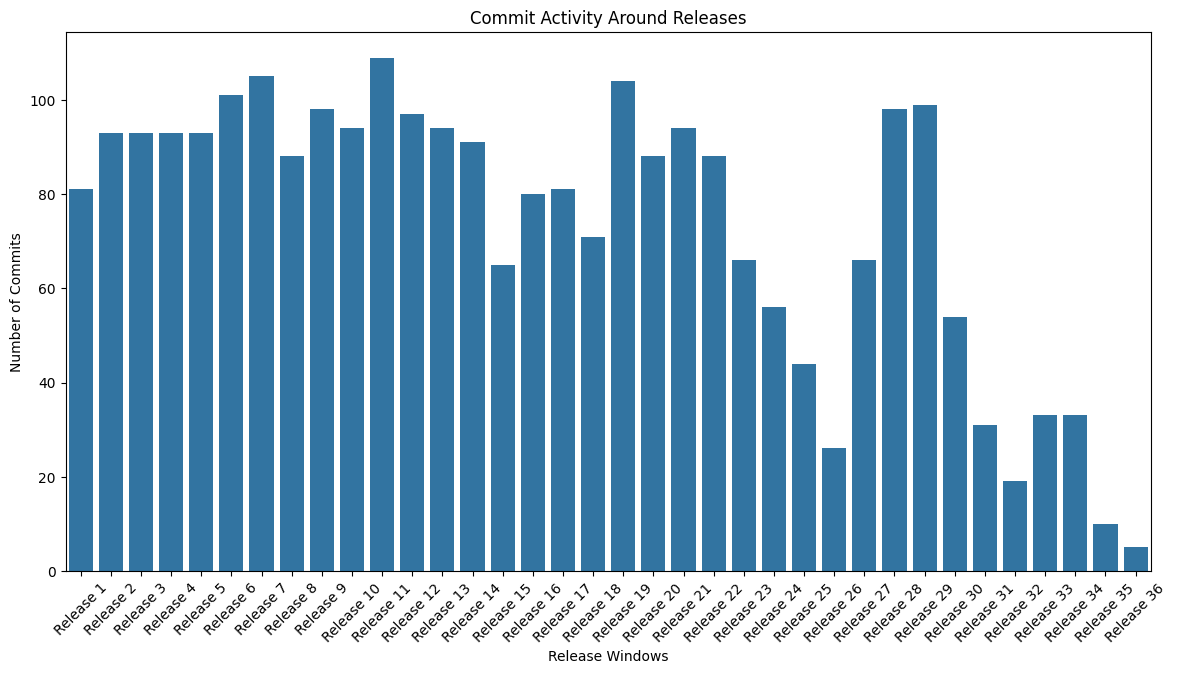

In [12]:
#@title Merge release dates with commits
release_dates = release_df[['tag_date']].copy()
release_dates['tag_date'] = pd.to_datetime(release_dates['tag_date'])
release_dates = release_dates.sort_values('tag_date')

# Create 2-week windows around releases
windows = []
for date in release_dates['tag_date']:
    start = date - pd.Timedelta(days=14)
    end = date + pd.Timedelta(days=14)
    windows.append((start, end))

# Calculate commit density in release windows
release_commits = []
for start, end in windows:
    mask = (commit_df['author_date'] >= start) & (commit_df['author_date'] <= end)
    release_commits.append(commit_df[mask].shape[0])

plt.figure(figsize=(14, 7))
sns.barplot(x=[f"Release {i+1}" for i in range(len(release_commits))], y=release_commits)
plt.title('Commit Activity Around Releases')
plt.xlabel('Release Windows')
plt.ylabel('Number of Commits')
plt.xticks(rotation=45)
plt.show()


In [13]:
#@title Convert all datetime columns to timezone-naive
commit_df['author_date'] = pd.to_datetime(commit_df['author_date']).dt.tz_convert(None)
release_df['tag_date'] = pd.to_datetime(release_df['tag_date']).dt.tz_localize(None)

# Create time-based features
commit_df['days_since_last_release'] = np.nan
last_release_date = None

# Convert author_date to datetime if not already
commit_df['author_date'] = pd.to_datetime(commit_df['author_date'])

for idx, row in commit_df.iterrows():
    current_date = row['author_date']
    # Filter releases up to current commit date
    past_releases = release_df[release_df['tag_date'] <= current_date]

    if not past_releases.empty:
        last_release_date = past_releases['tag_date'].max()
        days_since = (current_date - last_release_date).days
        commit_df.at[idx, 'days_since_last_release'] = days_since

# Create daily counts with proper date handling
daily_counts = commit_df.groupby(pd.Grouper(key='author_date', freq='D')).size().reset_index(name='commit_count')
daily_counts.rename(columns={'author_date': 'date'}, inplace=True)

# Merge with release information (both timezone-naive)
daily_counts = daily_counts.merge(
    release_df[['tag_date', 'is_major']],
    left_on='date',
    right_on='tag_date',
    how='left'
)

# Fill missing values and calculate days since last release
daily_counts['is_major'] = daily_counts['is_major'].fillna(False)
daily_counts['days_since_last_release'] = daily_counts.groupby(
    daily_counts['is_major'].cumsum())['date'].diff().dt.days.fillna(0)

print("Final daily counts:")
print(daily_counts[['date', 'commit_count', 'is_major', 'days_since_last_release']].head())


Final daily counts:
        date  commit_count  is_major  days_since_last_release
0 2020-03-08             1     False                      0.0
1 2020-03-09            11     False                      1.0
2 2020-03-10             1     False                      1.0
3 2020-03-11             0     False                      1.0
4 2020-03-12             5     False                      1.0


<ipython-input-13-76be05cb409d>:35: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [14]:
#@ Adding aditional features
# Ensure daily_counts is sorted by date
daily_counts = daily_counts.sort_values('date')

# Create lagged features
daily_counts['prev_day_commits'] = daily_counts['commit_count'].shift(1)
daily_counts['7_day_avg'] = daily_counts['commit_count'].rolling(7, min_periods=1).mean()

# Fill any remaining NA values
daily_counts = daily_counts.fillna(0)

# Now prepare model data
model_data = daily_counts[daily_counts['commit_count'] > 0]  # Filter days with commits
features = ['prev_day_commits', '7_day_avg', 'days_since_last_release']
target = 'commit_count'

print("Available columns:", model_data.columns.tolist())


Available columns: ['date', 'commit_count', 'tag_date', 'is_major', 'days_since_last_release', 'prev_day_commits', '7_day_avg']


<ipython-input-14-306a04d7554b>:10: FutureWarning:

Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



# 4. Model Development

Model RMSE: 2.14


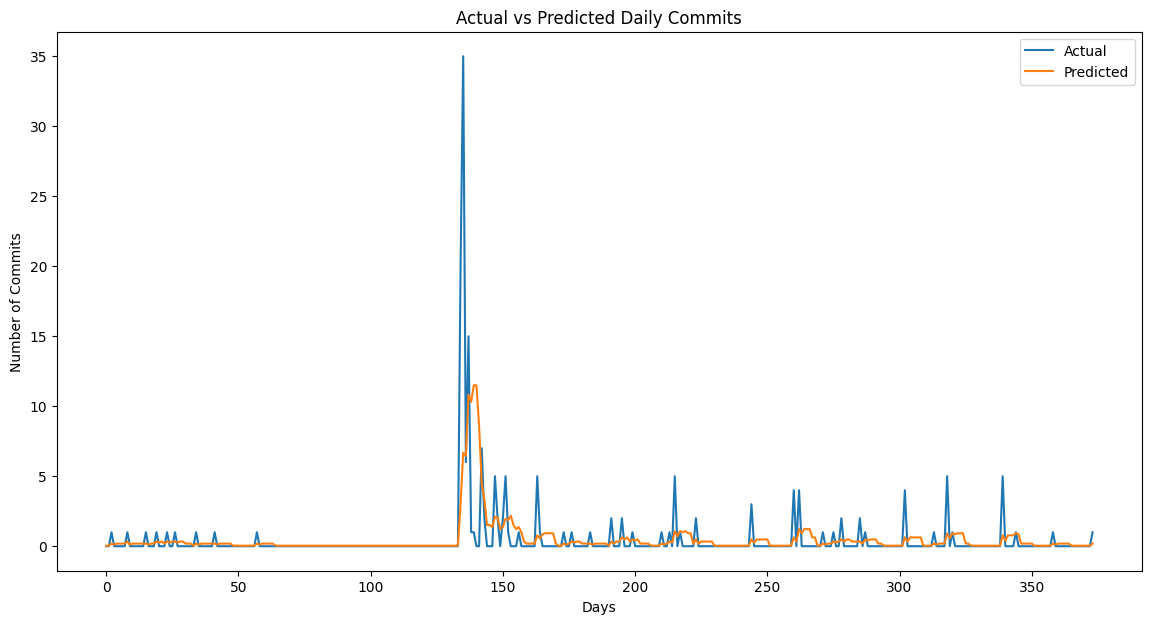

In [15]:
#@title Training the Model
# Prepare data for modeling
model_data = daily_counts.dropna()
features = ['prev_day_commits', '7_day_avg', 'days_since_last_release']
target = 'commit_count'

X = model_data[features]
y = model_data[target]

# Split data chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Visualize predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Daily Commits')
plt.xlabel('Days')
plt.ylabel('Number of Commits')
plt.legend()
plt.show()

# 5. Results and Insights

<ipython-input-16-90694d1cc942>:5: RuntimeWarning:

divide by zero encountered in divide



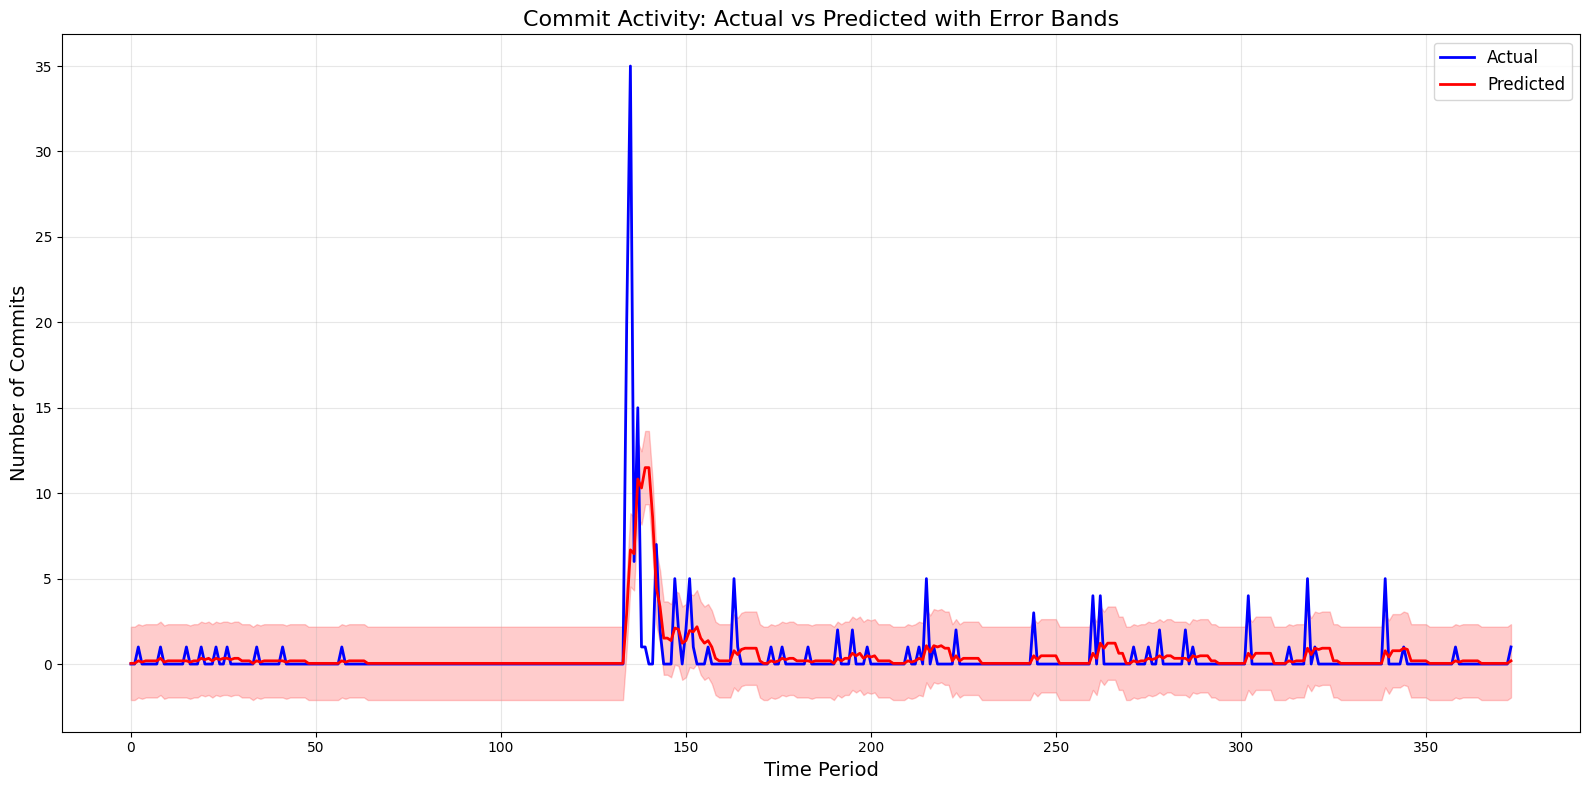

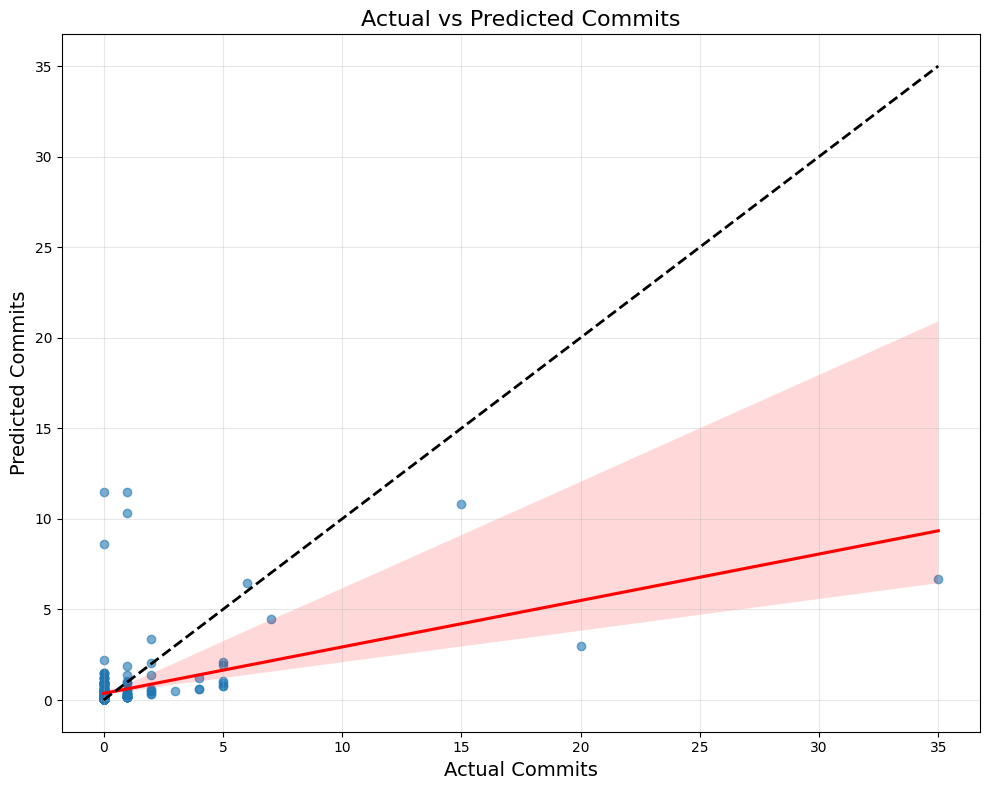

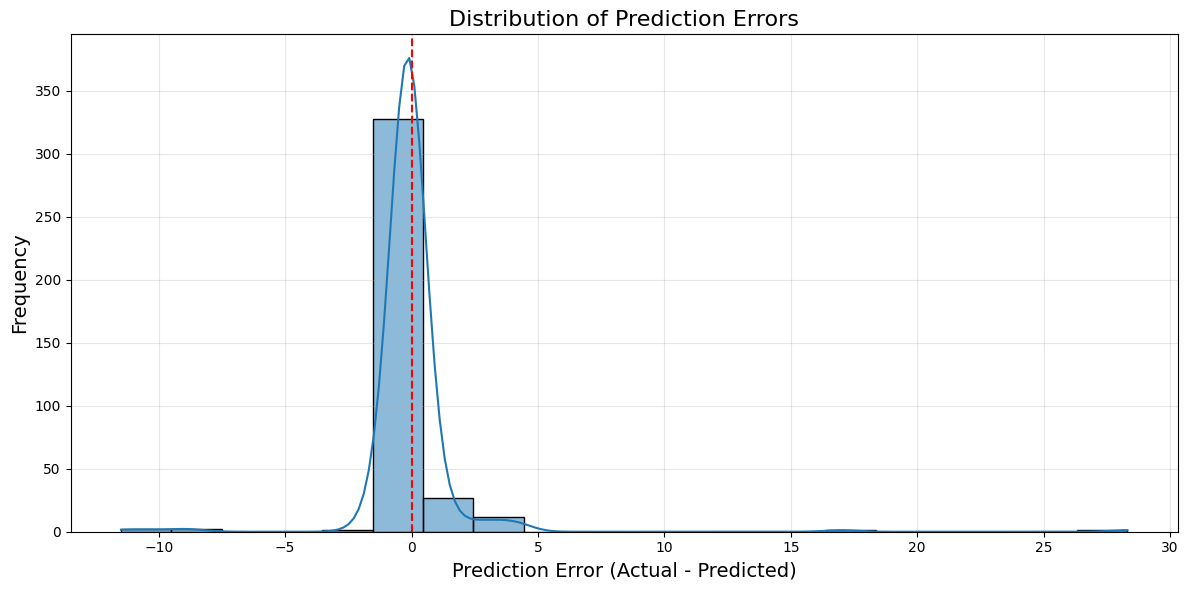


===== Model Performance Metrics =====
Root Mean Squared Error (RMSE): 2.14
Mean Absolute Error (MAE): 0.61
Mean Absolute Percentage Error (MAPE): inf%
R² Score: 0.1912


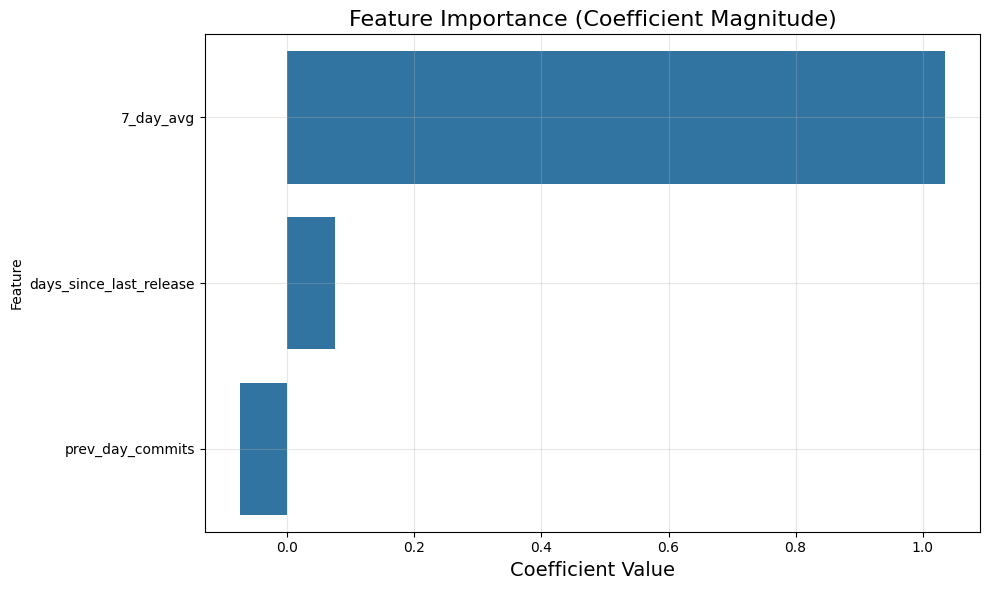

In [16]:
#@title Model Evaluation

# Calculate additional evaluation metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test.values - predictions) / y_test.values)) * 100

# Create a DataFrame with actual and predicted values for easier plotting
results_df = pd.DataFrame({
    'Date': model_data.iloc[train_size:].index,
    'Actual': y_test.values,
    'Predicted': predictions,
    'Error': y_test.values - predictions
})

# 1. Time series plot with confidence intervals
plt.figure(figsize=(16, 8))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red', linewidth=2)

# Add shaded area for prediction error
plt.fill_between(results_df.index,
                 results_df['Predicted'] - results_df['Error'].std(),
                 results_df['Predicted'] + results_df['Error'].std(),
                 color='red', alpha=0.2)

plt.title('Commit Activity: Actual vs Predicted with Error Bands', fontsize=16)
plt.xlabel('Time Period', fontsize=14)
plt.ylabel('Number of Commits', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 8))
sns.regplot(x=results_df['Actual'], y=results_df['Predicted'],
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.title('Actual vs Predicted Commits', fontsize=16)
plt.xlabel('Actual Commits', fontsize=14)
plt.ylabel('Predicted Commits', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Error distribution
plt.figure(figsize=(12, 6))
sns.histplot(results_df['Error'], kde=True, bins=20)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Print comprehensive metrics summary
print("\n===== Model Performance Metrics =====")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 5. Feature importance
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Coefficient Magnitude)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [65]:
#@title 30 Day Forecast
%%capture
# Generate next 30-day forecast
last_known = X.iloc[-1][['prev_day_commits', '7_day_avg', 'days_since_last_release']]
forecast = []

for day in range(30):
    pred = model.predict([last_known])[0]
    forecast.append(pred)
    last_known = pd.Series({
        'prev_day_commits': pred,
        '7_day_avg': (last_known['7_day_avg'] * 6 + pred) / 7,
        'days_since_last_release': last_known['days_since_last_release'] + 1
    })


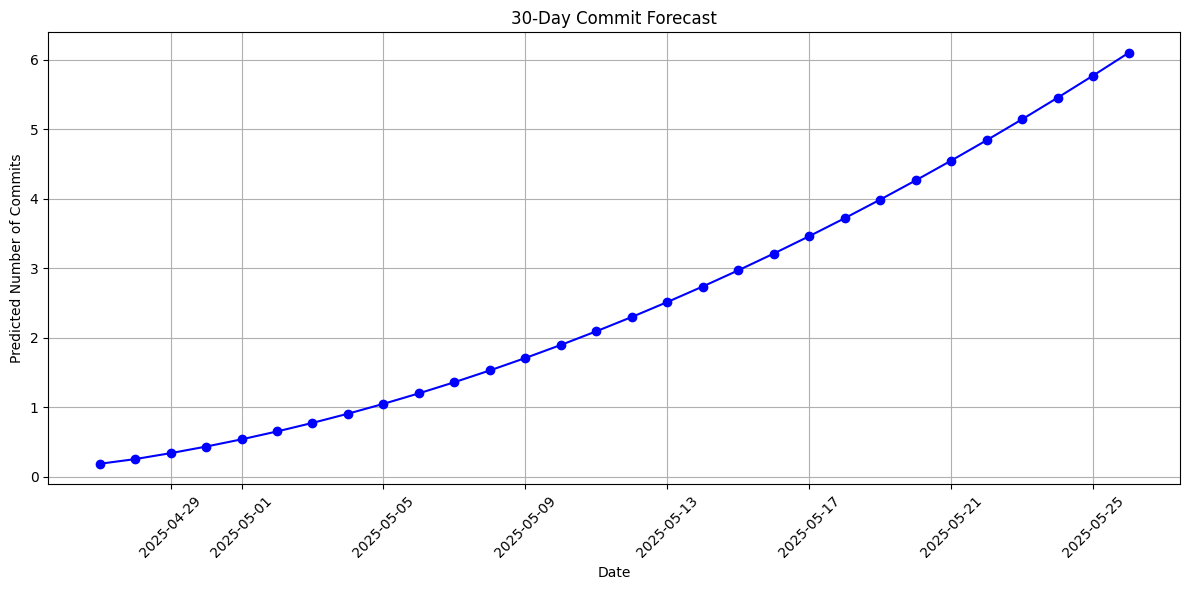

In [66]:
#@title Displaying the forecast

# Create a date range starting from the day after the last date
start_date = pd.to_datetime('today').normalize()  # or use last date in your dataset + 1
forecast_dates = pd.date_range(start=start_date, periods=30)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'date': forecast_dates, 'predicted_commits': forecast})

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['date'], forecast_df['predicted_commits'], marker='o', linestyle='-', color='blue')
plt.title('30-Day Commit Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Number of Commits')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Conclusion and Future Work

### Key Findings:
The model performance was not ideal, as reflected in the following metrics:

| Metric                             | Value   |
|------------------------------------|---------|
| Root Mean Squared Error (RMSE)     | 2.14    |
| Mean Absolute Error (MAE)          | 0.61    |
| Mean Absolute Percentage Error (MAPE) | inf%   |
| R² Score                           | 0.1912  |

While the model does provide some level of connection to the real data as seen in the graphing figure there is considerable room for improvement. As Fogel notes in their book being honest through your work about the potentiall issues is essential for the open source world and this note serves as "An accurate accounting of known deficiencies" (Fogel, 2023, p. 22) of this notebook. The relatively low R² score indicates that the linear regression model didn't explain much of the variance in the commit volume data, and the high MAPE points to the need for better accuracy.

### What Could Be Improved:
Given more time for the project, exploring different frameworks and model types could have helped me improve performance. For example, trying more sophisticated models such as decision trees, random forests, or even neural networks could yield more accurate predictions as these models can more easily factor in features that you might not see but have a very important impact.

The PyTorch Forecasting library was initially considered for use, but significant challenges arose during its implementation. These difficulties led me to just go with the linear regression model instead because of time restriction.

Additionally, working with a larger dataset would likely provide more reliable insights. The current analysis may be limited by the relatively small commit history, and with more data, the model's predictions could be more precise. For this however some further testing would need to be done with the PyDriller library to see if it could analyze large repos with 1 million+ commits.

### Future Implications:
One of the key future directions for this notebook is to make it easily adaptable to any project. The data wrangling and analysis processes are standardized as they both come in from the same library, allowing the same framework to be applied to different repositories with minimal modification. This flexibility would enable the notebook to analyze a wide range of open-source projects with ease.


Future versions of the notebook could include more feature selection options, such as incorporating additional commit metrics, pull request data, or issue tracking information. These additions would improve the model's ability to predict commit behavior and enhance the overall analysis. The book Producing Open Source Software decribes the importance of this for users as if this notebook is to be shared, as it will be on GitHub, many people will have the opproturnity to interact with the codebase and making it as easly understandable as possible is the best case for continued improvement.

Another potential larger research problem that could be answered with this notebook as a foundation would be regarding language. If given all of the computing and access to NLP models diving into the commit messages and the rhetoric behind communication I believe you could get some amazing insights, but to be fair a project like that is reserved for students to use for their dissertation and would take a considerable amount of time and resources. As discussed in the book we were given in class writing is "Perhaps the most important skill one can have in an open source environment."(Fogel, 2023, p. 117). It is essential to an open source projects life and testing this could show us insights into the importance of the language you choose to use within these repositories.


Finally, this project represents just the beginning. The takeaway from this extensive work is the potential for further development, including fine-tuning the models, adding more data sources, and improving the overall framework to analyze various open-source repositories. There is a lot of room to grow, and with additional iterations, this tool can become a more robust resource for understanding commit patterns in software development. As I do in many of my notebooks I set them up to be living documents to be used again and again so that once I finish an analysis I can go back and test other use cases I want to see.


## References

Fogel, K. (2023). *Producing open source software: How to run a successful free software project* (2nd ed.). https://producingoss.com/
